# Sea-level data at Ciutadella and Rissaga

In this notebook we will show how to read a variable (time series) from a [NetCDF file](http://www.unidata.ucar.edu/software/netcdf/) and apply a filter on it.

In [1]:
%matplotlib inline

Load python modules for the filtering and plotting.

In [2]:
import numpy as np
import netCDF4 as netcdf
import matplotlib.pyplot as plt
import datetime, time, calendar
import matplotlib.text as text
import matplotlib as mpl
from matplotlib import dates

## Configuration

Making the text bigger and the default color for lines black.

In [3]:
mpl.rcParams.update({'font.size': 20})
mpl.rcParams['lines.color'] = 'k'

Setting the format for the dates (day and month)

In [4]:
hfmt = dates.DateFormatter('%d %B')

## Data access

We will use [OPeNDAP](http://www.opendap.org/) protocol do extract the data from the netCDF file

In [5]:
datafile = "http://thredds.socib.es/thredds/dodsC/mooring/current_profiler/station_ciutadella-ime_awac001/L1/2015/dep0001_station-ciutadella_ime-awac001_L1_2015-06.nc"

Now we select the dates of interest.

In [6]:
timeinit,timeend = datetime.datetime(2015, 6, 10, 0, 0),datetime.datetime(2015, 6, 15, 0, 0)
tmin,tmax = time.mktime(timeinit.timetuple()), time.mktime(timeend.timetuple())

Then we load the variables time and pressure from the netCDF file, only for the period of interest.

Using "with ... as ..." to open a file, process its contents, and make sure to close it.

In [7]:
with netcdf.Dataset(datafile,'r+', format='NETCDF4') as nc:
    pressure_time = nc.variables['time'][:]
    goodtime = np.where(np.logical_and((pressure_time<=tmax), (pressure_time>=tmin)))[0]
    pressure = nc.variables['WTR_PRE'][goodtime]
    pressure_time = pressure_time[goodtime]

## Plotting

First we change the date format

In [8]:
dts = map(datetime.datetime.fromtimestamp, pressure_time) 
fds = dates.date2num(dts)

Now we can make a very simple plot to show the evolution of the pressure at 6 m depth.

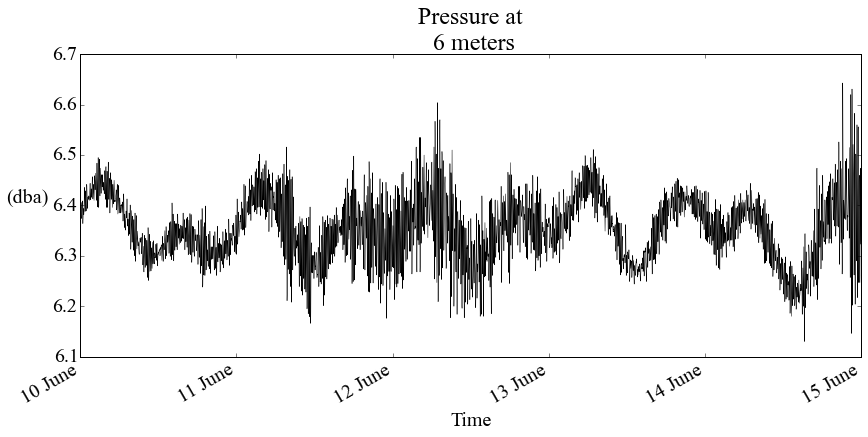

In [10]:
# Make a plot
fig = plt.figure(num=None, figsize=(14, 6))
ax = fig.add_subplot(111) 
plt.plot(fds,pressure, 'k', lw=0.5)
plt.xlabel('Time')
plt.ylabel('(dba)', ha='right', rotation=0)
plt.title('Pressure at \n 6 meters', fontsize=24)
ax.set_xlim(fds[0], fds[-1])
ax.xaxis.set_major_locator(dates.DayLocator())
ax.xaxis.set_major_formatter(hfmt)
fig.autofmt_xdate()

# Filtering

Now we want to apply a low-pass filter on the signal. For this, we will use the signal module available in scipy.

In [11]:
from scipy import signal

For the filter, it is necessary to set:
    <ul>
        <li> the cutoff frequency, </li>
        <li> the filter length, </li>
        <li> the window applied to the filter. </li>
    </ul>

## Filter design

In [12]:
N1=64                       # filter length 
windowsname = 'blackman'    # windows name

sample_rate = 1/60.0                # one data per minute
nyq_rate = sample_rate / 2.0        # Nyquist rate
frqcut = 1.0/(12*3600.)             # 12 hours
cutoff = frqcut/nyq_rate            # Cutoff relative to Nyquist rate

## Filter creation and application

In [13]:
taps1 = signal.firwin(N1, cutoff=cutoff, window=(windowsname))  
pressure_filtered = signal.lfilter(taps1, 1.0, pressure)
delay = 0.5 * (N1-1) / sample_rate

In [14]:
dts2 = map(datetime.datetime.fromtimestamp, pressure_time - delay)
fds2 = dates.date2num(dts2)  # converted

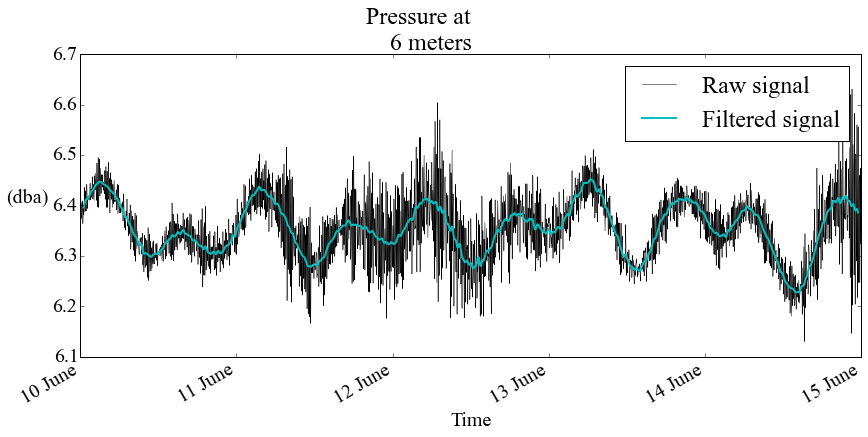

In [18]:
# Make a plot
fig = plt.figure(num=None, figsize=(14, 6))
ax = fig.add_subplot(111) 
plt.plot(fds,pressure, 'k', lw=0.5, label='Raw signal')
plt.plot(fds2[N1:],pressure_filtered[N1:], 'c', linewidth=2, zorder=2, label='Filtered signal')
plt.xlabel('Time')
plt.ylabel('(dba)', ha='right', rotation=0)
plt.title('Pressure at \n 6 meters', ha='right', fontsize=24)
plt.legend()
ax.set_xlim(fds[0], fds[-1])
ax.xaxis.set_major_locator(dates.DayLocator())
ax.xaxis.set_major_formatter(hfmt)
fig.autofmt_xdate()
plt.show()

The filtered signal reproduce the low-frequency variations, as expected. But we would like to test the implemented filter with different parameters, to see how the resulting filtered signal is modified.

## Testing the filter cutoff frequency

We will test cutoff frequencies from 3 to 36 hours, with a quite short filter length (32).

In [26]:
# Filter length
N1 = 64
Tcut = np.array((3, 6,12,24,36))         # cutoff period in hours
delay = 0.5 * (N1-1) / sample_rate

We create a loop using these values and generate a figure to compare the results.

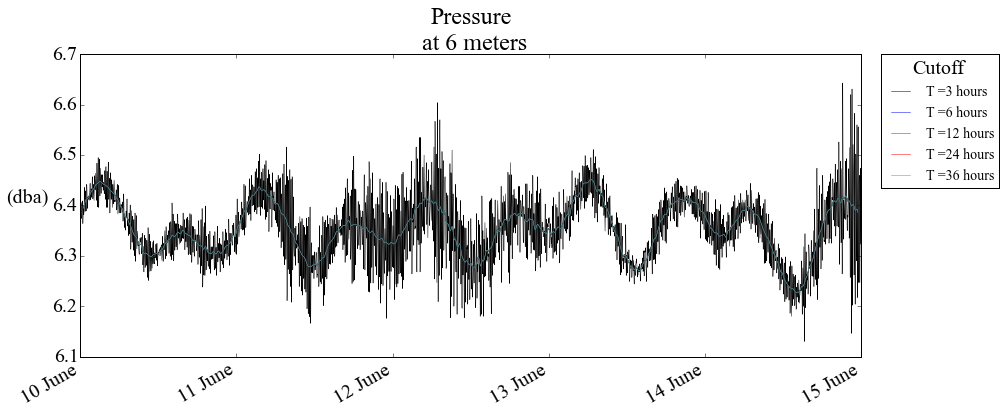

In [27]:
fig=plt.figure(num=None, figsize=(14, 6))
ax = fig.add_subplot(111)
plt.title('Pressure\n at 6 meters', rotation=0, fontsize=24)

zord = 2
for T in Tcut:
    
    frqcut = 1.0/(T*3600.)
    cutoff = frqcut/nyq_rate

    # Build and apply filter
    taps1 = signal.firwin(N1, cutoff=cutoff, window=(windowsname))
    pressure_filtered = signal.lfilter(taps1, 1.0, pressure)

    dts = map(datetime.datetime.fromtimestamp, pressure_time -delay ) 
    fds = dates.date2num(dts) # converted

    # Compute pressure anomaly
    plt.plot(fds[N1-1:],pressure_filtered[N1-1:], 
             linewidth=0.5, zorder=zord, label='T =' +str(T) + ' hours' )
    
    zord+=1


dts = map(datetime.datetime.fromtimestamp, pressure_time) 
fds = dates.date2num(dts) # converted

ax.xaxis.set_major_formatter(hfmt)
plt.plot(fds,pressure,'k',lw=0.5,zorder=1)
plt.ylabel('(dba)', ha='right', rotation=0)
ax.xaxis.set_major_locator(dates.DayLocator())
ax.xaxis.set_major_formatter(hfmt)
fig.autofmt_xdate()
ax.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0., fontsize=14, title='Cutoff')

## Testing the filter length

We will test various filter lengths from 16 to 128, with a cutoff corresponding to 12 hours.

In [28]:
# Filter length
N=np.array((16, 32,64,128))
frqcut = 1.0/(12*3600.)             # 12 hours

Create the plot

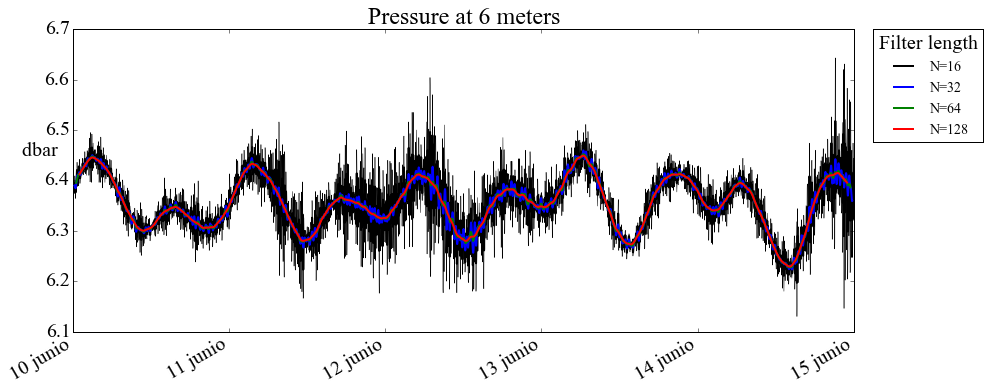

In [29]:
fig=plt.figure(num=None, figsize=(14, 6))
ax = fig.add_subplot(111)
plt.title('Pressure at 6 meters',rotation=0,fontsize=24)

zord = 2
for N1 in N:
    # Build and apply filter
    taps1 = signal.firwin(N1, cutoff=cutoff, window=(windowsname))
    delay = 0.5 * (N1-1) / sample_rate 
    pressure_filtered = signal.lfilter(taps1, 1.0, pressure)

    dts = map(datetime.datetime.fromtimestamp, pressure_time -delay ) 
    fds = dates.date2num(dts) # converted

    plt.plot(fds[N1-1:],pressure_filtered[N1-1:], linewidth=2,zorder=zord,label='N='+str(N1))
    zord+=1

dts = map(datetime.datetime.fromtimestamp, pressure_time) 
fds = dates.date2num(dts) # converted

ax.xaxis.set_major_formatter(hfmt)
plt.plot(fds,pressure,'k',lw=0.5,zorder=1)
plt.ylabel('dbar \n   ',rotation=0)
ax.xaxis.set_major_locator(dates.DayLocator())
ax.xaxis.set_major_formatter(hfmt)
fig.autofmt_xdate()
ax.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0., fontsize=14, title='Filter length')

An increased filter length provides a smoother filtered signal. 

## Testing the filter window

Now the goal is to test different windows for the filter.

In [30]:
# Filter Windows
windows = ('blackman','blackmanharris','bohman','hann','nuttall')

N1 = 128
frqcut = 1.0/(24*3600.)
cutoff = frqcut/nyq_rate

And we can create the figure with the different filtered signals.

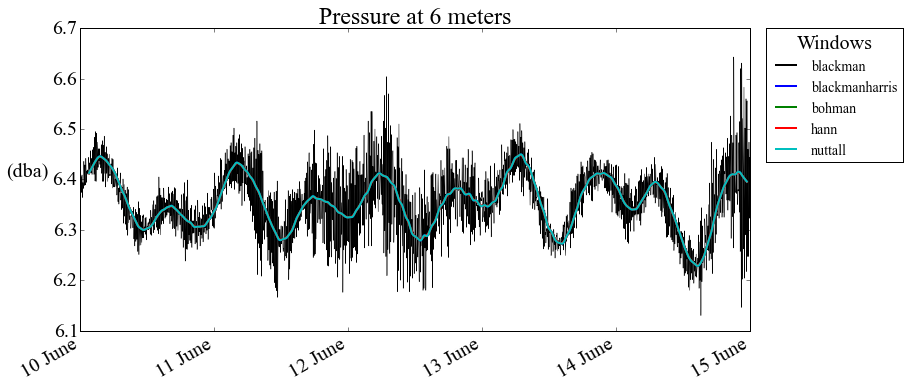

In [31]:
fig=plt.figure(num=None, figsize=(12, 6))
ax = fig.add_subplot(111)
plt.title('Pressure at 6 meters',rotation=0,fontsize=24)

zord = 2
for w in windows:

    # Build and apply filter
    taps1 = signal.firwin(N1, cutoff=cutoff, window=(w))
    pressure_filtered = signal.lfilter(taps1, 1.0, pressure)

    # Modify date so that it can be plotted
    # (map apply the function to every item of iterable)
    dts = map(datetime.datetime.fromtimestamp, pressure_time -delay ) 
    fds = dates.date2num(dts) # converted

    # Compute pressure anomaly
    #plt.plot(fds[:-N1],pressure_filtered[N1:],lw=1,zorder=2)
    plt.plot(fds[N1-1:],pressure_filtered[N1-1:], linewidth=2,zorder=zord,label=w)
    zord+=1

dts = map(datetime.datetime.fromtimestamp, pressure_time) 
fds = dates.date2num(dts) # converted

ax.xaxis.set_major_formatter(hfmt)
plt.plot(fds,pressure,'k',lw=0.5,zorder=1)
plt.ylabel('(dba)', ha='right', rotation=0)
ax.xaxis.set_major_locator(dates.DayLocator())
ax.xaxis.set_major_formatter(hfmt)
ax.set_xlim(fds[0], fds[-1])
fig.autofmt_xdate()
ax.legend(bbox_to_anchor=(1.025, 1), loc=2, borderaxespad=0., fontsize=14, title='Windows')

We see that at these frequencies, the window type used on the filter has only a weak influence of the filtered signal.